In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.utils import load_img, img_to_array
# from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
# from keras.layers.wrappers import Bidirectional
# from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical
import tensorflow as tf

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
captionPath= '/content/drive/MyDrive/Colab Notebooks/NLP_project/captions.txt'
train_path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/train_image.txt'
test_path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/test_image.txt'
images_path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/'
# glove_path = '../input/glove6b'

Reading **Data**

In [4]:
val = open(captionPath,'r').read()
print(val[:900])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg,A little girl 


Separating image id and caption and putting in the dictionary


In [5]:
des = {}
for line in val.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in des:
              des[image_id] = []
          des[image_id].append(image_desc)
print(des['1000268201_693b08cb0e'])          

['child in a pink dress is climbing up a set of stairs in an entry way .', 'girl going into a wooden building .', 'little girl climbing into a wooden playhouse .', 'little girl climbing the stairs to her playhouse .', 'little girl in a pink dress going into a wooden cabin .']


In [6]:
import re

for key in des.keys():
    des[key] = [re.sub(r'[^\w]', ' ', i) for i in des[key]]


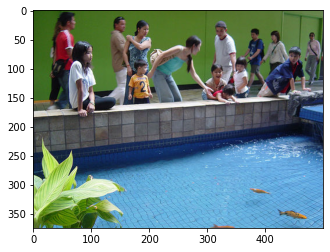

['sit and watch the fish moving in the pond',
 'stare at the orange fish  ',
 'people are standing near a fish pond  ',
 'children watching fish in a pool  ',
 'are several people and children looking into water with a blue tiled floor and goldfish  ']

In [7]:
pic = '/12830823_87d2654e31.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
des['12830823_87d2654e31']

In [9]:
l = []
for key, desc_list in des.items():
    for desc in desc_list:
        l.append(key + ' ' + desc)
new_des = '\n'.join(l)
print(l[1:200])

['1000268201_693b08cb0e child in a pink dress is climbing up a set of stairs in an entry way  ', '1000268201_693b08cb0e girl going into a wooden building  ', '1000268201_693b08cb0e little girl climbing into a wooden playhouse  ', '1000268201_693b08cb0e little girl climbing the stairs to her playhouse  ', '1000268201_693b08cb0e little girl in a pink dress going into a wooden cabin  ', '1001773457_577c3a7d70 black dog and a spotted dog are fighting', '1001773457_577c3a7d70 black dog and a tri colored dog playing with each other on the road  ', '1001773457_577c3a7d70 black dog and a white dog with brown spots are staring at each other in the street  ', '1001773457_577c3a7d70 dogs of different breeds looking at each other on the road  ', '1001773457_577c3a7d70 dogs on pavement moving toward each other  ', '1002674143_1b742ab4b8 little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  ', '1002674143_1b742ab4b8 little girl is sitting in front of a large paint

In [10]:
d = open(train_path,'r').read()
data =[]
for line in d.split('\n'):
    if len(line) > 1:
      i = line.split('.')[0]
      data.append(i)

train = set(data)
# print(dataset)

In [11]:
img = glob.glob(images_path + '*.jpg')
# print(img)
train_images = set(open(train_path , 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)
print(train_img)
test_images = set(open(test_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)
print(test_img)

['/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/2140747429_62cfd89ae9.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/2141065212_463a6997e1.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/2147199188_d2d70b88ec.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/2144050118_3e7d2e05b1.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/2144049642_070cf541b4.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/215214751_e913b6ff09.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/2158247955_484f0a1f11.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/2149968397_a7411729d1.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/2151300603_248a9fe715.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/2156726763_034ecd2e39.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP_project/Images/2157003092_eaeb977789.jpg', '/content/drive/MyDrive/Colab Notebooks/NLP

In [12]:
train_desc = {}
for line in new_des.split('\n'):
  # print(line)
    tokens = line.split()
    img_id, img_des = tokens[0], tokens[1:]
    # print(train)
    if img_id in train:
        if img_id not in train_desc:
            train_desc[img_id] = []
        descrip = 'initial ' + ' '.join(img_des) + ' last'
        train_desc[img_id].append(descrip)

In [13]:
all = []
for key, val in train_desc.items():
    for i in val:
        all.append(i)
print(all)

['initial child in a pink dress is climbing up a set of stairs in an entry way last', 'initial girl going into a wooden building last', 'initial little girl climbing into a wooden playhouse last', 'initial little girl climbing the stairs to her playhouse last', 'initial little girl in a pink dress going into a wooden cabin last', 'initial black dog and a spotted dog are fighting last', 'initial black dog and a tri colored dog playing with each other on the road last', 'initial black dog and a white dog with brown spots are staring at each other in the street last', 'initial dogs of different breeds looking at each other on the road last', 'initial dogs on pavement moving toward each other last', 'initial little girl covered in paint sits in front of a painted rainbow with her hands in a bowl last', 'initial little girl is sitting in front of a large painted rainbow last', 'initial small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it last', 'in

In [52]:
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1013


In [53]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1
print(vocab_size)

1014


In [16]:
all_des = []
for key in train_desc.keys():
    [all_des.append(d) for d in train_desc[key]]
lines = all_des
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 34


In [17]:
glove_path='/content/drive/MyDrive/Colab Notebooks/NLP_project/glove.6B.200d.txt'
embeddings_index = {} 
# f = 'glove.6B.200d.txt'), encoding="utf-8")
f = open(glove_path, 'r')
# f = open(glove_path,'r').read()
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [18]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

96112376/96112376 [==============================] - 1s 0us/step


In [20]:
def preprocess(images_path):
    img = load_img(images_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [21]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

1/1 [==============================] - 0s 276ms/step


In [22]:
from keras.layers import add
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      202800      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [23]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [25]:
from keras_preprocessing.sequence import pad_sequences
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [26]:
epochs = 30
batch_size = 3
steps = len(train_desc)//batch_size

generator = data_generator(train_desc, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
400/400 [==============================] - 185s 450ms/step - loss: 4.4675
Epoch 2/30
400/400 [==============================] - 185s 462ms/step - loss: 3.7127
Epoch 3/30
400/400 [==============================] - 184s 459ms/step - loss: 3.4030
Epoch 4/30
400/400 [==============================] - 180s 449ms/step - loss: 3.1897
Epoch 5/30
400/400 [==============================] - 183s 459ms/step - loss: 3.0213
Epoch 6/30
400/400 [==============================] - 185s 461ms/step - loss: 2.8982
Epoch 7/30
400/400 [==============================] - 178s 444ms/step - loss: 2.7811
Epoch 8/30
400/400 [==============================] - 182s 454ms/step - loss: 2.6755
Epoch 9/30
400/400 [==============================] - 182s 455ms/step - loss: 2.5715
Epoch 10/30
400/400 [==============================] - 185s 463ms/step - loss: 2.4851
Epoch 11/30
400/400 [==============================] - 184s 460ms/step - loss: 2.4122
Epoch 12/30
400/400 [==============================] - 189s 472

In [54]:
def optimalSearch(photo):
    in_text = 'initial'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'last':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [56]:
def predictions(image, beam_index):
    start = [wordtoix["initial"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'last':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

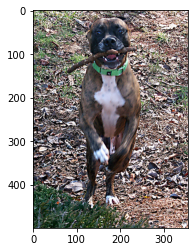

brown dogs are running through the grass
K = 3: brown dogs are running through the grass
K = 5: dog runs through the snow
K = 7: running in the snow
K = 10: running in the snow
K = 1: brown dogs are running through the grass


In [57]:
pic = '2198964806_c57b0534d3.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print(optimalSearch(image))
print("K = 3:",predictions(image, beam_index = 3))
print("K = 5:",predictions(image, beam_index = 5))
print("K = 7:",predictions(image, beam_index = 7))
print("K = 10:",predictions(image, beam_index = 10))
print("K = 1:",predictions(image, beam_index = 1))

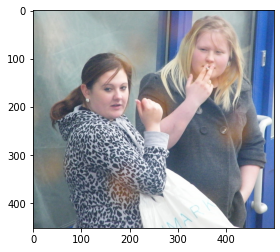

Greedy: woman wearing a blue dress looks pictures to the camera
K = 1: woman wearing a blue dress looks pictures to the camera
K = 3: girl in a red top piece top and khaki shorts looks at the camera
K = 5: girl in a red top piece top while sunglasses looks at the camera


In [42]:
pic = list(encoding_test.keys())[55]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print(optimalSearch(image))
print("K = 1:",predictions(image, beam_index = 1))
print("K = 3:",predictions(image, beam_index = 3))
print("K = 5:",predictions(image, beam_index = 5))

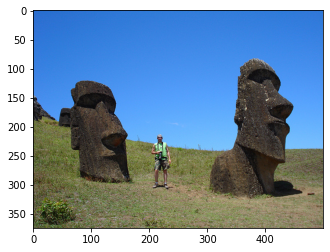

Greedy: man is standing by a cliff taking another takes a picture while another man watches
K = 1: man is standing by a cliff taking another takes a picture while another man watches
K = 3: man taking a while another man wearing a backpack
K = 5: group of people stand in front of a mountain look down at the beach


In [38]:
pic = list(encoding_test.keys())[101]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print(optimalSearch(image))
print("K = 1:",predictions(image, beam_index = 1))
print("K = 3:",predictions(image, beam_index = 3))
print("K = 5:",predictions(image, beam_index = 5))

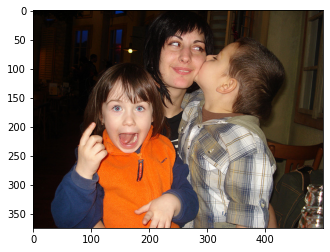

Greedy: young boys are wearing black foam of while laughing
K = 1: young boys are wearing black foam of while laughing
K = 3: little girl in a striped shirt and blue shorts is kneeling while holding a toy
K = 5: little girl in a striped shirt and blue shorts is kneeling while holding a toy


In [60]:
pic = list(encoding_test.keys())[25]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",optimalSearch(image))
print("K = 1:",predictions(image, beam_index = 1))
print("K = 3:",predictions(image, beam_index = 3))
print("K = 5:",predictions(image, beam_index = 5))